In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Add this line
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os


In [35]:
class LaneAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(LaneAttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        attention = torch.sigmoid(self.conv1(x))
        x = self.conv2(x)
        x = x * attention
        return x

class LaneATT(nn.Module):
    def __init__(self):
        super(LaneATT, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)  # Output 1 channel for mask
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        x = self.conv3(x)  # Last convolution layer outputting mask shape
        return x  # Output shape should be [batch_size, 1, height, width]




In [36]:
from PIL import Image  # Ensure PIL is imported for image handling
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Define your LaneDataset class
class LaneDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, transform=None):
        self.frames_dir = frames_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.frames = sorted(os.listdir(frames_dir))
        self.masks = sorted(os.listdir(masks_dir))
        assert len(self.frames) == len(self.masks), "Number of frames and masks should be the same"

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_dir, self.frames[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        frame = Image.open(frame_path).convert('RGB')  # Use PIL Image for frames
        mask = Image.open(mask_path).convert('L')  # Use PIL Image for grayscale masks

        if self.transform:
            frame = self.transform(frame)
            mask = self.transform(mask)

        return frame, mask


In [46]:
# Define the transformations
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])


# Set paths
frames_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\frames'
masks_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\lane-masks'

# Load the dataset
dataset = LaneDataset(frames_dir, masks_dir, transform=transform)

# Check the number of samples in the dataset
print("Number of samples in dataset:", len(dataset))

# Create a DataLoader
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch size as needed


Number of samples in dataset: 3626


In [47]:
import os
print("Frames directory exists:", os.path.exists(frames_dir))
print("Masks directory exists:", os.path.exists(masks_dir))
print("Number of frame files:", len(os.listdir(frames_dir)))
print("Number of mask files:", len(os.listdir(masks_dir)))


Frames directory exists: True
Masks directory exists: True
Number of frame files: 3626
Number of mask files: 3626


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Initialize model, loss function, and optimizer
model = LaneATT().to(device)  # Assuming LaneATT is your model
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the device

# Number of epochs
num_epochs = 20  # Adjust epochs as needed

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for frames, masks in train_loader:
        frames, masks = frames.to(device), masks.to(device)  # Move data to the appropriate device (CPU/GPU)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(frames)  # Forward pass

        # Upsample the outputs to match the mask size
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/20], Loss: 0.2123
Epoch [2/20], Loss: 0.1592
Epoch [3/20], Loss: 0.1459
Epoch [4/20], Loss: 0.1415
Epoch [5/20], Loss: 0.1393
Epoch [6/20], Loss: 0.1371
Epoch [7/20], Loss: 0.1353
Epoch [8/20], Loss: 0.1336
Epoch [9/20], Loss: 0.1324
Epoch [10/20], Loss: 0.1305
Epoch [11/20], Loss: 0.1293
Epoch [12/20], Loss: 0.1286
Epoch [13/20], Loss: 0.1273
Epoch [14/20], Loss: 0.1268
Epoch [15/20], Loss: 0.1256
Epoch [16/20], Loss: 0.1254
Epoch [17/20], Loss: 0.1241
Epoch [18/20], Loss: 0.1234
Epoch [19/20], Loss: 0.1226
Epoch [20/20], Loss: 0.1218


In [48]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for i, (frames, masks) in enumerate(test_loader):
            frames = frames.to(device)
            masks = masks.to(device)

            outputs = model(frames)  # Get predictions from the model
            predictions = torch.sigmoid(outputs) > 0.5  # Apply a threshold to get binary output

            # Move tensors back to CPU and convert them to NumPy arrays
            frames = frames.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Remove batch dimension, convert to (H, W, C)
            masks = masks.cpu().squeeze(0).squeeze(0).numpy()  # Remove batch and channel dimensions
            predictions = predictions.cpu().squeeze(0).squeeze(0).numpy()  # Same for predictions

            # Plot original frame, ground truth mask, and model prediction
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(frames)
            plt.title("Original Frame")

            plt.subplot(1, 3, 2)
            plt.imshow(masks, cmap='gray')
            plt.title("Ground Truth Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions, cmap='gray')
            plt.title("Model Prediction")

            plt.show()

            if i == 5:  # Visualize the first 5 predictions
                break


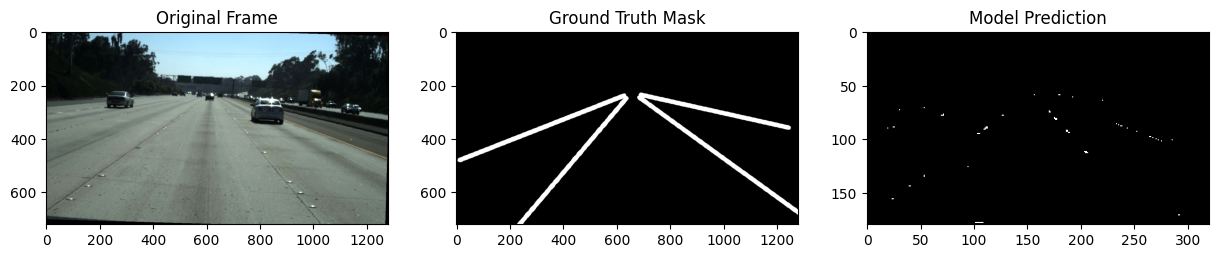

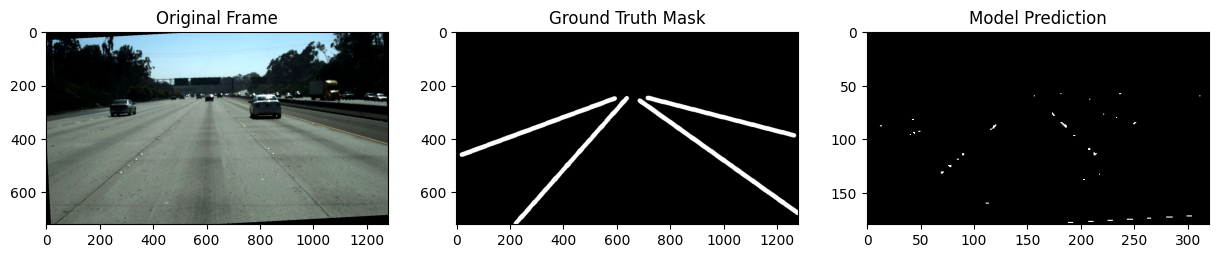

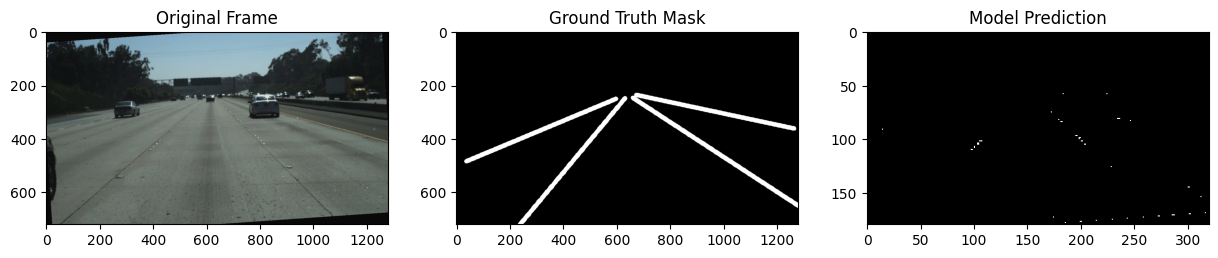

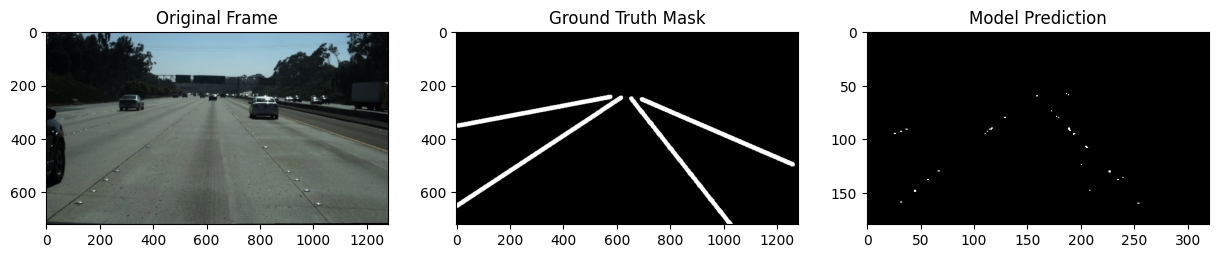

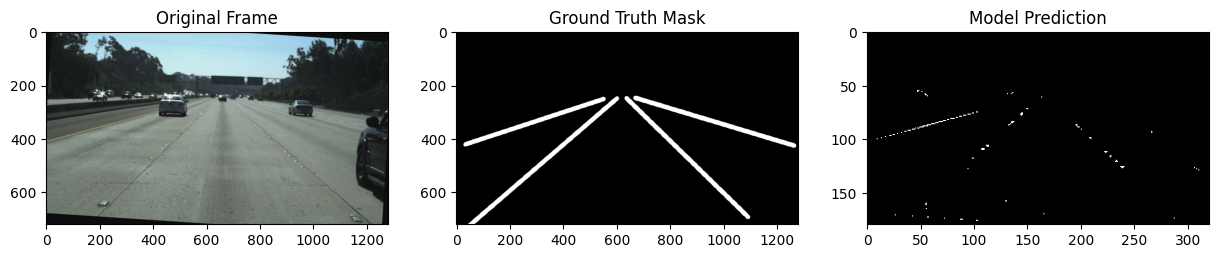

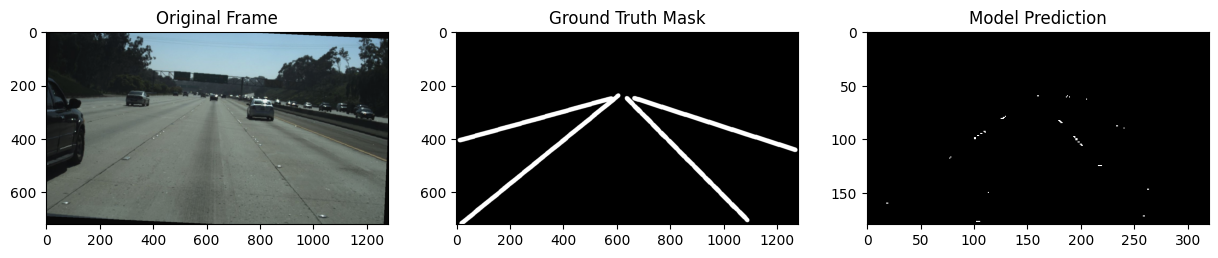

In [49]:
# Load test dataset (similar to training)
test_frames_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\frames'  # Adjust as needed
test_masks_dir = r'C:\Users\Stephen Fernandes\Desktop\ProjEct\training\lane-masks'  # Adjust as needed

test_dataset = LaneDataset(test_frames_dir, test_masks_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size of 1 for visualization

# Visualize predictions
visualize_predictions(model, test_loader)
